In [163]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import tifffile as tfl
import h5py
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

In [164]:
os.chdir('D:/Landslide')

In [165]:
%ls

 Volume in drive D is Remote Sensing and GIS data
 Volume Serial Number is 78A5-4D3B

 Directory of D:\Landslide

04/17/2022  05:36 PM    <DIR>          .
04/17/2022  05:36 PM    <DIR>          ..
04/17/2022  04:43 PM    <DIR>          .ipynb_checkpoints
04/17/2022  05:00 PM         1,043,617 0.EDA for Landslide4Sense.ipynb
04/17/2022  05:36 PM         1,282,304 1. Data Loader.ipynb
04/16/2022  11:04 PM         1,607,733 Slope_and_Aspect_Map_reading.ipynb
04/17/2022  05:36 PM    <DIR>          TrainData
04/14/2022  08:06 PM     2,442,381,619 TrainData.zip
               4 File(s)  2,446,315,273 bytes
               4 Dir(s)  16,564,674,560 bytes free


In [166]:
folder_list = sorted(os.listdir('D:/Landslide/TrainData/img'))
mask_folder_list =sorted(os.listdir(r'D:/Landslide/TrainData/mask'))
#mask_folder_list.remove('collection.json')


In [167]:
print(f'Image name is {folder_list[110]}')
print(f'Mask name is {mask_folder_list[110]}')
print(f'Number of items in Folder List {len(folder_list)}')
print(f'Number of items in mask list {len(mask_folder_list)}')

Image name is image_1099.h5
Mask name is mask_1099.h5
Number of items in Folder List 3798
Number of items in mask list 3798


In [168]:
# # Dataloader for Pytorch
# dataset_dir='D:/Landslide/TrainData/img/'
# mask_dir='D:/Landslide/TrainData/mask/'

# class data_loader():
#     def __init__(self,dataset_dir,mask_dir):
#         self.dataset_dir = dataset_dir
#         self.mask_dir = mask_dir
        
#         folder_list = os.listdir(self.dataset_dir)
#         mask_folder_list = os.listdir(self.mask_dir)

#     def __getitem__(self,idx):
#         image = self.get_image(folder_list[idx])
#         mask = self.get_mask_image(mask_folder_list[idx])
    
#         return image,mask
    
#     def get_image(self,folder_dir):
#         image = h5py.File(dataset_dir+folder_dir,'r')
#         image = np.array(image.get('img'))
# #         image = tfl.imread(dataset_dir+folder_dir)
        
        
#         return image
    
#     def get_mask_image(self,folder_dir):
#         image = h5py.File(mask_dir+folder_dir,'r')
#         image = np.array(image.get('mask'))
# #         label = np.array(Image.open(mask_dir+folder_dir+'/labels.tif'))
        
#         return image
    
# training_data = data_loader(dataset_dir,mask_dir)

# for i in range(10):
#     n = np.random.randint(1,100)
#     fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,10))
#     ax1.imshow(training_data[n][0][:,:,1])
#     ax2.imshow(training_data[n][1])

# Tensorflow DataLoader

In [169]:

dataset_dir='D:/Landslide/TrainData/img/'
mask_dir='D:/Landslide/TrainData/mask/'

class data_loader(keras.utils.Sequence):
    def __init__(self, batch_size, img_size,num_classes,dataset_dir,mask_dir):
        self.batch_size = batch_size
        self.img_size = img_size
        self.dataset_dir = dataset_dir
        self.mask_dir = mask_dir
        self.num_classes= num_classes
        self.folder_list = sorted(os.listdir(self.dataset_dir))
        self.mask_folder_list = sorted(os.listdir(self.mask_dir))


    def __len__(self):
        return len(self.folder_list)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.folder_list[i : i + self.batch_size]
        batch_target_img_paths = self.mask_folder_list[i : i + self.batch_size]

        # load images
        x = np.zeros((self.batch_size,) + self.img_size + (14,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = self.get_image(self.dataset_dir+path)
            x[j] = img

        # load masks
        y = np.zeros((self.batch_size,) + self.img_size, dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = self.get_mask_image(self.mask_dir+path)
            y[j] = img  

        return x,y



    def get_image(self,folder_dir):
        image = h5py.File(folder_dir,'r')
        image = np.array(image.get('img'))
#         image = tfl.imread(dataset_dir+folder_dir)
        
        
        return image
    
    def get_mask_image(self,folder_dir):
        image = h5py.File(folder_dir,'r')
        image = np.array(image.get('mask'))
#         label = np.array(Image.open(mask_dir+folder_dir+'/labels.tif'))
        
        return image


In [197]:
sat_data1 = data_loader(100,(128,128),14,dataset_dir,mask_dir)
val_gen = data_loader(10,(128,128),14,dataset_dir,mask_dir)

In [198]:
len(sat_data1),len(val_gen)

(3798, 3798)

(10, 128, 128, 14)
(10, 128, 128)


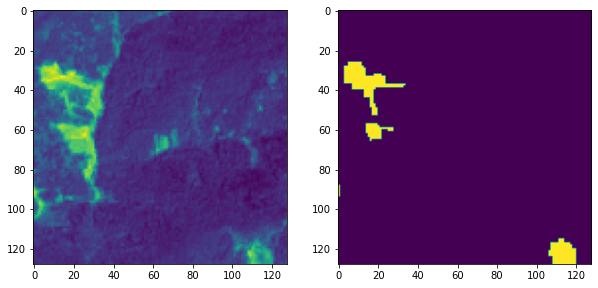

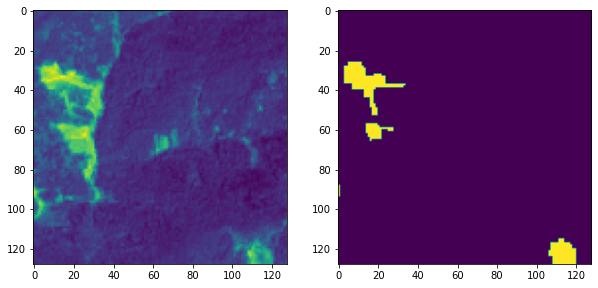

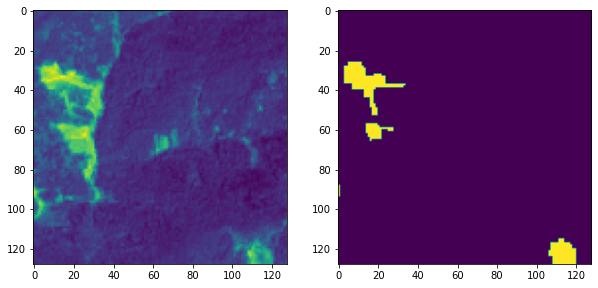

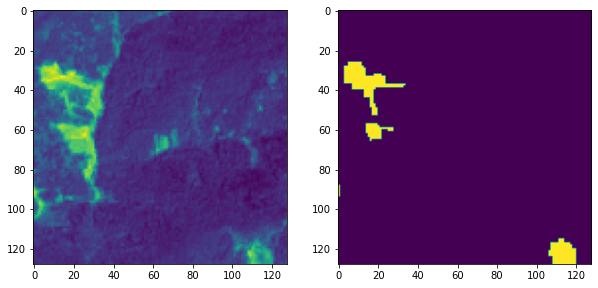

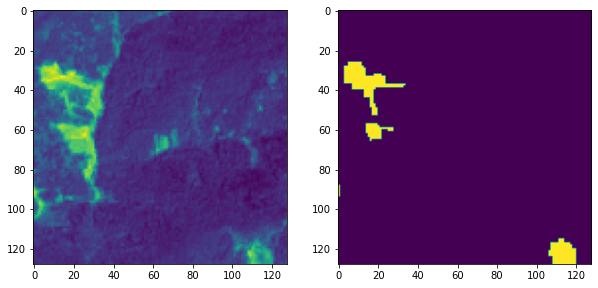

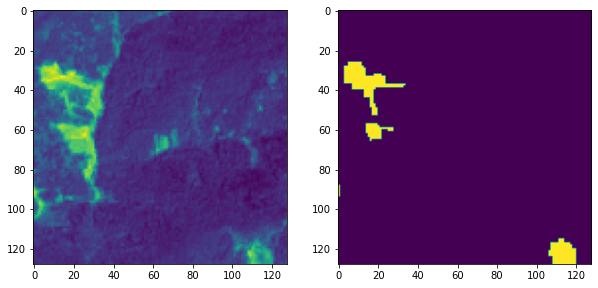

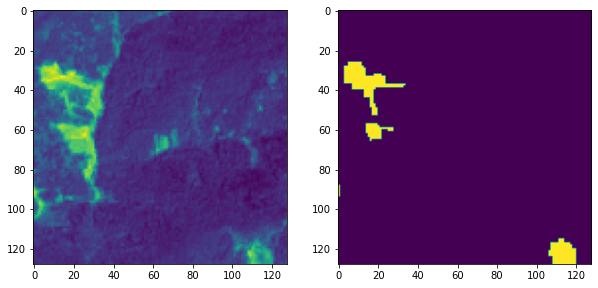

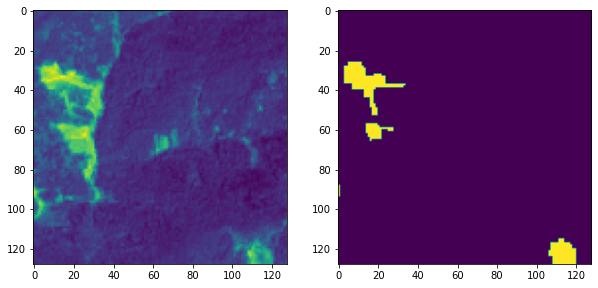

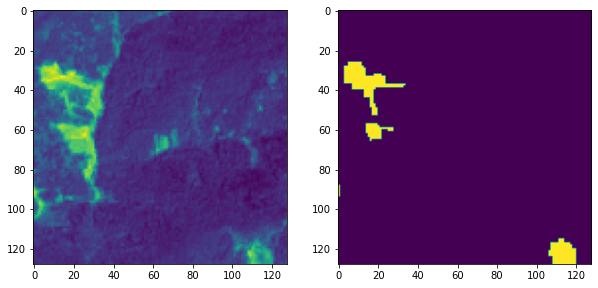

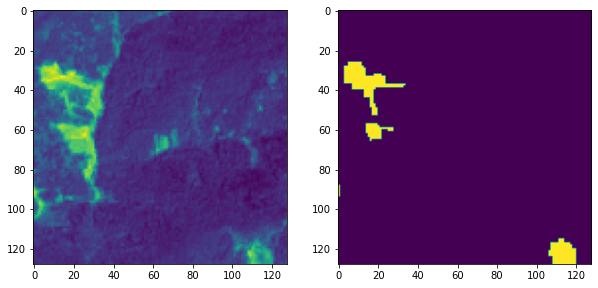

In [196]:
x,y = val_gen[0]
print(x.shape)
print(y.shape)
for i in range(10):
    n = np.random.randint(1,2)
    fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,10))
    # ax1.imshow(x[n][0][:,:,1])
    ax1.imshow(x[n][:,:,1])
    ax2.imshow(y[n])

(100, 128, 128, 14)
(100, 128, 128)


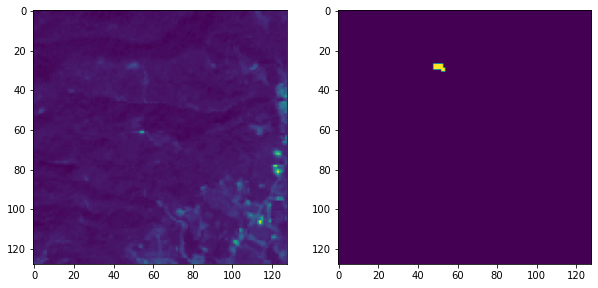

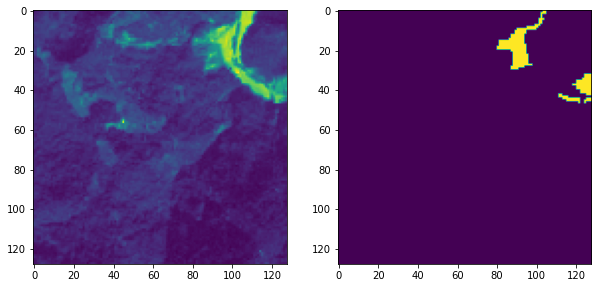

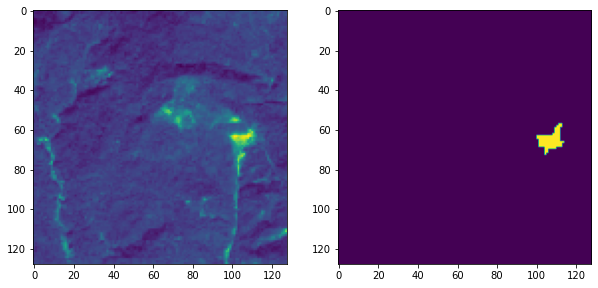

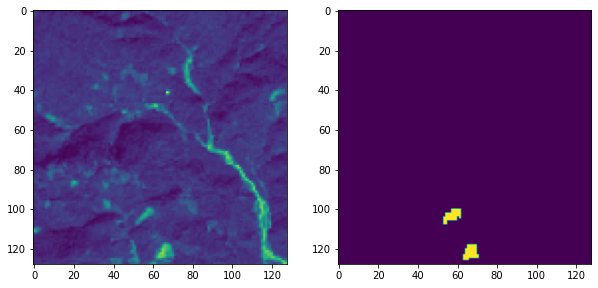

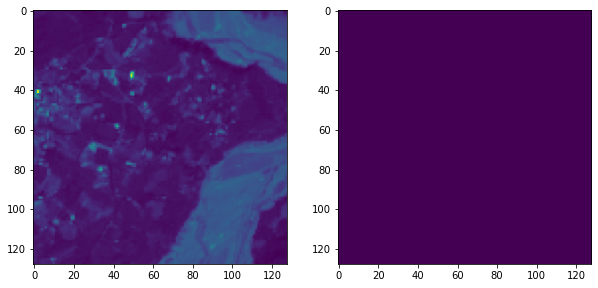

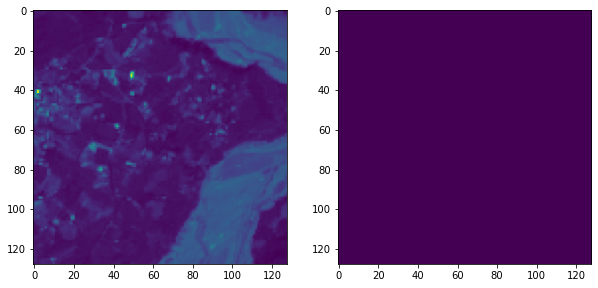

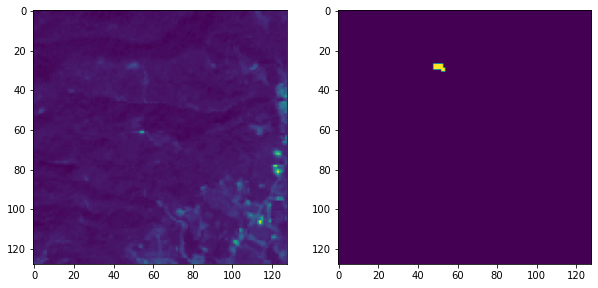

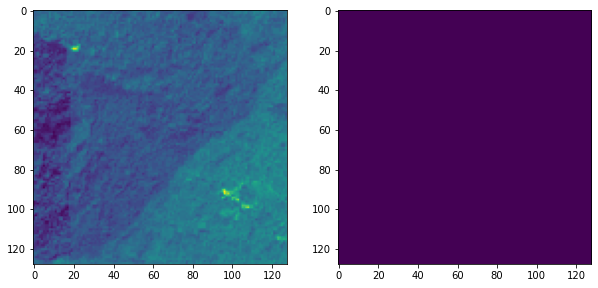

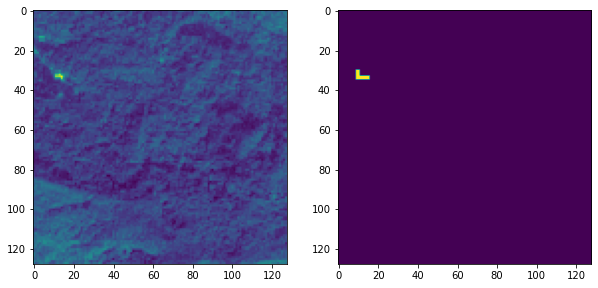

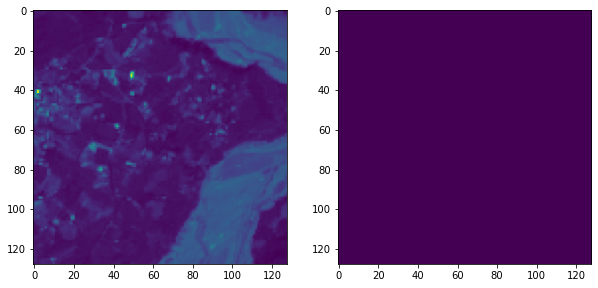

In [199]:
x,y = sat_data1[3]
print(x.shape)
print(y.shape)
for i in range(10):
    n = np.random.randint(1,10)
    fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,10))
    # ax1.imshow(x[n][0][:,:,1])
    ax1.imshow(x[n][:,:,1])
    ax2.imshow(y[n])